# Malicious Domain Dataset - Random Forest Classifier

In [17]:
import pandas as pd

# Load preprocessed dataset
datasource = "preprocessed.csv"
data = pd.read_csv(datasource)
data.Class.value_counts()

0    32613
1     3815
Name: Class, dtype: int64

## Resampling

As the preprocessed dataset is unbalanced, we resample to create a balanced set for training and testing.

In [18]:
from sklearn.utils import resample

sample_size = min(data.Class.value_counts())

malicious = resample(data.loc[data["Class"] == 0], replace=False, n_samples=sample_size, random_state=42)
benign = resample(data.loc[data["Class"] == 1], replace=False, n_samples=sample_size, random_state=42)

balanced = pd.concat([malicious, benign])
balanced.Class.value_counts()

X = balanced.drop(columns=["Class"])
y = balanced["Class"]

## Cross-validation

Here we assess how well a Random Forest classifier will generalize the dataset by performing 10-fold cross-validation.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

# Build pipeline to transform and fit data
stages = [
    ("scaler", StandardScaler()), # Standardize the data such that mean = 0 and variance = 1
    ("selector", SelectKBest(k=6)), # Select the k best parameters using ANOVA F-value 
    ("classifier", RandomForestClassifier())] # Init Random Forest classifier

pipeline = Pipeline(stages)

# Perform cross validation using the pipeline
folds = 10
metrics = ["accuracy", "f1", "precision", "recall"]
scores = cross_validate(pipeline, X, y, scoring=metrics, cv=folds)

# Determine cross validation scores
scores = pd.DataFrame.from_dict(scores)
scores

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
0,0.239348,0.015891,0.967235,0.967062,0.970899,0.963255
1,0.238916,0.016546,0.973788,0.973958,0.966408,0.981627
2,0.227260,0.015876,0.973788,0.973684,0.976253,0.971129
3,0.214280,0.015808,0.959371,0.960205,0.939698,0.981627
4,0.212008,0.015646,0.968545,0.968254,0.976000,0.960630
5,0.209293,0.015539,0.969856,0.969777,0.973615,0.965969
6,0.210652,0.015744,0.965924,0.966408,0.954082,0.979058
7,0.211009,0.015825,0.969856,0.969856,0.971129,0.968586
8,0.215042,0.016558,0.971166,0.971204,0.971204,0.971204
9,0.213321,0.015398,0.982962,0.983007,0.981723,0.984293


In [20]:
scores.mean()

fit_time          0.219113
score_time        0.015883
test_accuracy     0.970249
test_f1           0.970342
test_precision    0.968101
test_recall       0.972738
dtype: float64

## Finalized Model

In [21]:
# Partition data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

# Build pipeline to transform and fit data
stages = [
    ("scaler", StandardScaler()), # Standardize the data such that mean = 0 and variance = 1
    ("selector", SelectKBest(k=6)), # Select the k best parameters using ANOVA F-value 
    ("classifier", RandomForestClassifier())] # Init Random Forest classifier

pipeline = Pipeline(stages)

pipeline.fit(X_train, y_train)

# Score the resulting model and determine which features were selected
score = pipeline.score(X_test, y_test)
k_features = X.columns.values[pipeline['selector'].get_support()]

print("Model accuraccy: %f" % (score))
print("Selected features: %s" % (k_features))

Model accuraccy: 0.967453
Selected features: ['StrangeCharacters' 'NumericRatio' 'VowelRatio' 'ConsonantSequence'
 'NumericSequence' 'DomainLength']


### Visualizations

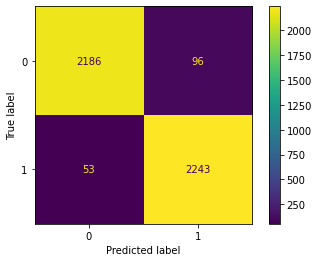

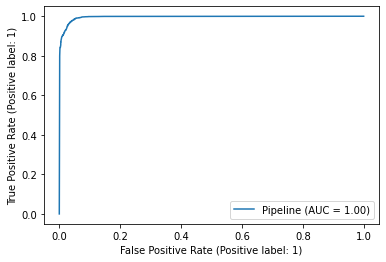

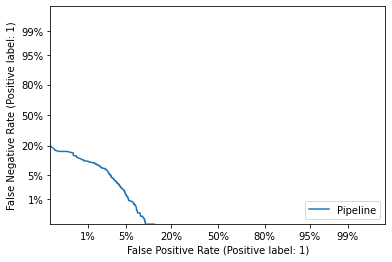

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, DetCurveDisplay

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

DetCurveDisplay.from_estimator(pipeline, X_test, y_test)